# imaging systematics versus the target density


In [1]:
import numpy as np
import healpy as hp
from astropy.table import Table, vstack

from pfstarget import util as U
from pfstarget import cuts as Cuts

In [2]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
npix = hp.nside2npix(128)  # Total number of pixels
hp_area = hp.nside2pixarea(128, degrees=True) # sq. deg in each pixel

In [4]:
# read in effective healpixel areas computed from randoms (this is only for tracts in group 0, 1, 2)
# this pre-computed
hp_map_effarea = np.load('hp_map_effarea.nside128.0_2.npy')

## get target density

In [8]:
for i in range(3): 
    tract = Table.read('/Users/hahnchanghoon/projects/pfstarget/bin/hsc/sql/database/s23-colorterm/sql/%i.fits' % i)
    # prepare tract 
    hsc = Cuts._prepare_hsc(tract,  dust_extinction='sfd98', zeropoint=True)
    
    # apply PFS Cosmology target selection 
    is_pfscosmo = Cuts.isCosmology(hsc)
    targets = hsc[is_pfscosmo] 

    hpix = hp.ang2pix(128, np.radians(90.0 - targets['DEC']), np.radians(targets['RA']))
    uhpix, nhpix = np.unique(hpix, return_counts=True)

    if i == 0: hp_targets_sfd98 = np.zeros(npix)
    hp_targets_sfd98[uhpix] += nhpix

In [7]:
for i in range(3): 
    tract = Table.read('/Users/hahnchanghoon/projects/pfstarget/bin/hsc/sql/database/s23-colorterm/sql/%i.fits' % i)
    # prepare tract 
    hsc = Cuts._prepare_hsc(tract,  dust_extinction='desi', zeropoint=True)
    
    # apply PFS Cosmology target selection 
    is_pfscosmo = Cuts.isCosmology(hsc)
    targets = hsc[is_pfscosmo] 

    hpix = hp.ang2pix(128, np.radians(90.0 - targets['DEC']), np.radians(targets['RA']))
    uhpix, nhpix = np.unique(hpix, return_counts=True)

    if i == 0: hp_targets_desi = np.zeros(npix)
    hp_targets_desi[uhpix] += nhpix

## get imaging systematics

In [9]:
for i in range(3): 
    if i == 0: 
        tracts = Table.read('/Users/hahnchanghoon/projects/pfstarget/bin/hsc/sql/database/s23-colorterm/sql/%i.fits' % i)
    else: 
        tracts = vstack([tracts, Table.read('/Users/hahnchanghoon/projects/pfstarget/bin/hsc/sql/database/s23-colorterm/sql/%i.fits' % i)])

In [10]:
# prepare tract 
hsc = Cuts._prepare_hsc(tracts,  dust_extinction='sfd98')

# apply PFS Cosmology target selection 
is_pfscosmo = Cuts.isCosmology(hsc)

pqa_sfd98 = U.patch_qa(tracts['tract'], tracts['patch'])[is_pfscosmo]

In [11]:
# prepare tract 
hsc = Cuts._prepare_hsc(tracts,  dust_extinction='desi', zeropoint=True)

# apply PFS Cosmology target selection 
is_pfscosmo = Cuts.isCosmology(hsc)

pqa_desi = U.patch_qa(tracts['tract'], tracts['patch'])[is_pfscosmo]

In [12]:
def get_image_systematics(pqa, sys_name, method=np.median): 
    ''' given patch_qa table and name of systematics return systematics for healpixels
    '''
    hpix = hp.ang2pix(128, np.radians(90.0 - pqa['dec']), np.radians(pqa['ra']))
    uhpix = np.unique(hpix)

    hp_sys = np.zeros(npix)
    for u in uhpix: 
        is_hpix = (hpix == u)
        hp_sys[u] = method(pqa[sys_name][is_hpix])
    return hp_sys

# target density versus imaging systematics

In [13]:
theta, phi = hp.pix2ang(128, np.arange(npix))
_ra = np.degrees(phi)           
_dec = 90.0 - np.degrees(theta) 

in_radec_box = ((_ra > 30.) & (_ra < 38) & (_dec > -6) & (_dec < -2))

/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site

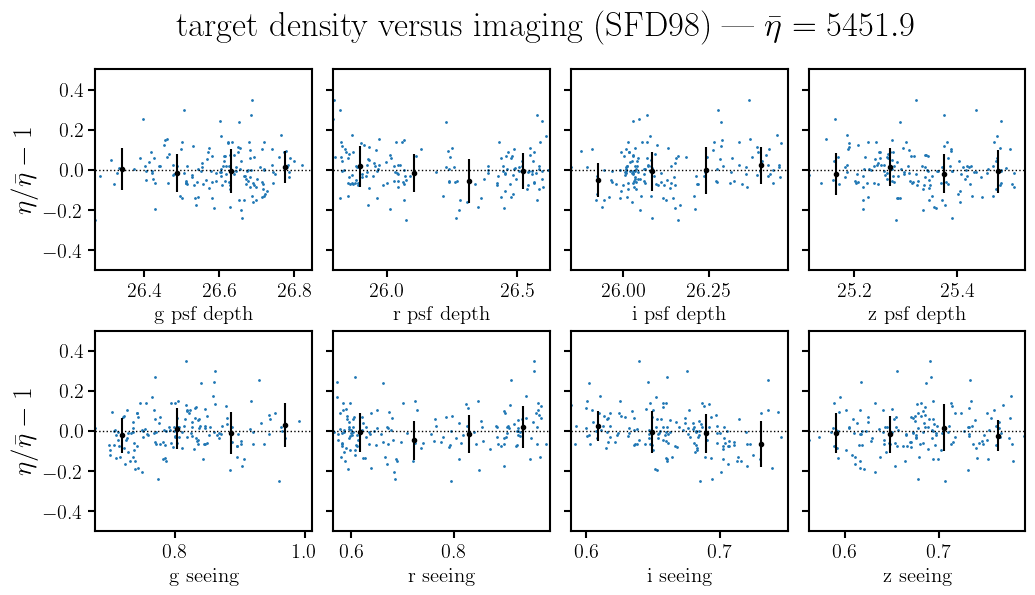

In [14]:
# more than 200 targets and within the RA and DEC specified above
_cut = (hp_targets_sfd98 > 200.) & in_radec_box

eta_bar = np.mean(hp_targets_sfd98[_cut]/hp_map_effarea[_cut])

fig = plt.figure(figsize=(12,6))
for i, band in enumerate(['g', 'r', 'i', 'z']): 

    for j, name in enumerate(['mag_psf_depth', 'seeing']): 
        sub = fig.add_subplot(2,4,i+1+j*4)
        col = band+name
    
        _sys = get_image_systematics(pqa_sfd98, col, method=np.mean)
        y = hp_targets_sfd98[_cut]/hp_map_effarea[_cut]/eta_bar - 1
        sub.scatter(_sys[_cut], y, s=1)
    
        bins = np.linspace(_sys[_cut].min(), _sys[_cut].max(), 5)
        ibin = np.digitize(_sys[_cut], bins) - 1.
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        
        med, std = [], [] 
        for _i in range(len(bins) - 1):
            y_in_bin = y[ibin == _i]
            if len(y_in_bin) > 0:
                med.append(np.median(y_in_bin))
                std.append(np.std(y_in_bin))
            else:
                med.append(np.nan)  
                std.append(np.nan)  
        sub.errorbar(bin_centers, med, yerr=std, fmt='.k')
        sub.axhline(0., color='k', linestyle=':', lw=1)
        
        if i > 0: sub.set_yticklabels([])
        else: sub.set_ylabel(r'$\eta/\bar{\eta} - 1$', fontsize=20)
        if j == 0: sub.set_xlabel(col.replace('_', ' ').replace('mag', ''), fontsize=15)
        if j == 1: sub.set_xlabel(col.replace('seeing', ' seeing'), fontsize=15)
        sub.set_xlim(_sys[_cut].min(), _sys[_cut].max())
        sub.set_ylim(-0.5, 0.5)

fig.suptitle('target density versus imaging (SFD98) --- '+r'$\bar{\eta} = %.1f$' % eta_bar, fontsize=25)
fig.subplots_adjust(wspace=0.1, hspace=0.3)

/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/hahnchanghoon/mamba/envs/pfs/lib/python3.12/site

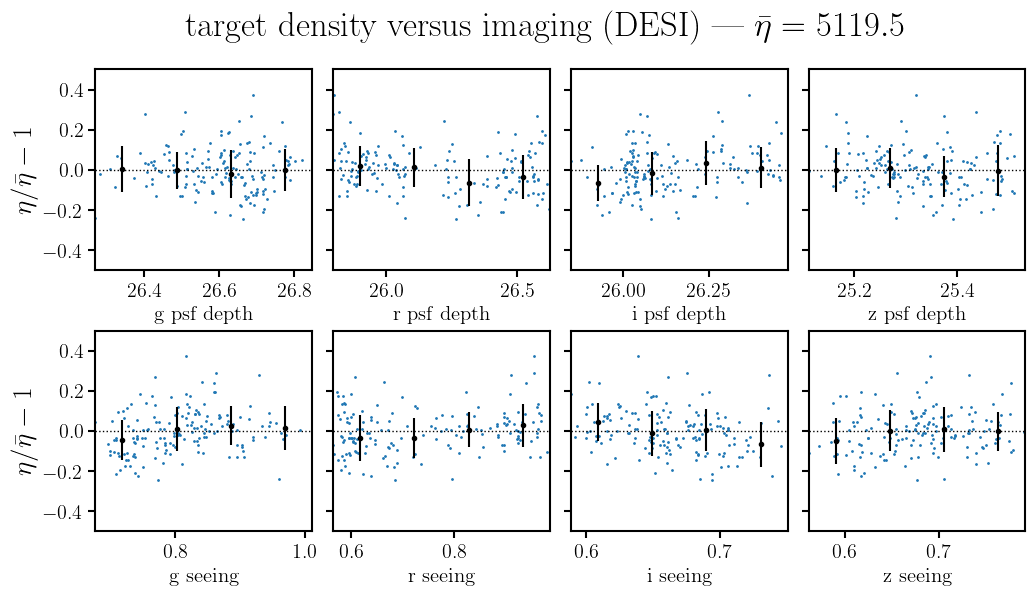

In [15]:
_cut = (hp_targets_desi > 200.) & in_radec_box

eta_bar = np.mean(hp_targets_desi[_cut]/hp_map_effarea[_cut])

fig = plt.figure(figsize=(12,6))
for i, band in enumerate(['g', 'r', 'i', 'z']): 

    for j, name in enumerate(['mag_psf_depth', 'seeing']): 
        sub = fig.add_subplot(2,4,i+1+j*4)
        col = band+name
    
        _sys = get_image_systematics(pqa_desi, col, method=np.mean)
        y = hp_targets_desi[_cut]/hp_map_effarea[_cut]/eta_bar - 1
        sub.scatter(_sys[_cut], y, s=1)
    
        bins = np.linspace(_sys[_cut].min(), _sys[_cut].max(), 5)
        ibin = np.digitize(_sys[_cut], bins) - 1.
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        
        med, std = [], [] 
        for _i in range(len(bins) - 1):
            y_in_bin = y[ibin == _i]
            if len(y_in_bin) > 0:
                med.append(np.median(y_in_bin))
                std.append(np.std(y_in_bin))
            else:
                med.append(np.nan)  
                std.append(np.nan)  
        sub.errorbar(bin_centers, med, yerr=std, fmt='.k')
        sub.axhline(0., color='k', linestyle=':', lw=1)
        
        if i > 0: sub.set_yticklabels([])
        else: sub.set_ylabel(r'$\eta/\bar{\eta} - 1$', fontsize=20)
        if j == 0: sub.set_xlabel(col.replace('_', ' ').replace('mag', ''), fontsize=15)
        if j == 1: sub.set_xlabel(col.replace('seeing', ' seeing'), fontsize=15)
        sub.set_xlim(_sys[_cut].min(), _sys[_cut].max())
        sub.set_ylim(-0.5, 0.5)

fig.suptitle('target density versus imaging (DESI) --- '+r'$\bar{\eta} = %.1f$' % eta_bar, fontsize=25)
fig.subplots_adjust(wspace=0.1, hspace=0.3)